In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET = '/content/drive/MyDrive/Data_for_Task_1.csv'

Mounted at /content/drive


In [ ]:
from google.colab import files

print('Upload Arial.ttf')
uploaded = files.upload()
print('Upload Arial-Bold.ttf')
uploaded = files.upload()

Upload Arial.ttf


Saving Arial.ttf to Arial.ttf
Upload Arial-Bold.ttf


Saving Arial-Bold.ttf to Arial-Bold.ttf


In [ ]:
import string

from matplotlib.colors import ListedColormap
from matplotlib import colormaps
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

In [ ]:
font_filename = 'Arial.ttf'
fm.fontManager.addfont(font_filename)
fm.FontProperties(fname=font_filename)

font_filename = 'Arial-Bold.ttf'
fm.fontManager.addfont(font_filename)
fm.FontProperties(fname=font_filename)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif'] = ['Arial-Bold']

# Preparation

In [ ]:
df = pd.read_csv(DATASET)
df.drop(labels=['id'], axis=1, inplace=True)
df.dropna(axis=1, inplace=True)
df['diagnosis'].replace(('M', 'B'), (1, 0), inplace=True)

In [ ]:
df_no_outliers = None
for column in df.columns:
    Q_parameter = 0.05

    Q_lower = df[column].quantile(Q_parameter)
    Q_upper = df[column].quantile(1 - Q_parameter)
    IQR = Q_upper - Q_lower

    lower_bound = Q_lower - 1.5 * IQR
    upper_bound = Q_upper + 1.5 * IQR

    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    df_no_outliers = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
df = df_no_outliers

In [ ]:
y = np.array(df['diagnosis'])
X = np.array(df.drop(labels=['diagnosis'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# EDA

In [ ]:
def get_label(index):
    alphabet = string.ascii_lowercase
    if index < len(alphabet):
        return alphabet[index]
    else:
        return alphabet[(index // len(alphabet)) - 1] + alphabet[index % len(alphabet)]


plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.sans-serif'] = ['Arial-Bold']

colormap = colormaps['viridis']

fig, ax = plt.subplots(6, 5, figsize=(32, 32))
columns = df.drop(labels=['diagnosis'], axis=1).columns
for index, variable in enumerate(columns):
    i = index // 5
    j = index % 5
    data_to_plot = [df[variable].loc[df['diagnosis'] == 0], df[variable].loc[df['diagnosis'] == 1]]
    parts = ax[i][j].violinplot(data_to_plot, positions=[2, 4], widths=1.5, showmeans=False, showmedians=True)

    color = index * 0.8 / len(columns)

    for pc in parts['bodies']:
        pc.set_facecolor(colormap(color))

    parts['cmedians'].set_colors(colormap(color))
    parts['cbars'].set_colors(colormap(color))
    parts['cmaxes'].set_colors(colormap(color))
    parts['cmins'].set_colors(colormap(color))

    ax[i][j].set(xlabel='Neoplasm classification', ylabel=variable)
    ax[i][j].set_xticks([2, 4])
    ax[i][j].set_xticklabels(['Benign', 'Malignant'])

    letter = get_label(index)
    ax[i][j].text(0.5, -0.16, f'({letter})', transform=ax[i][j].transAxes, ha='center', va='center')

plt.show()

In [ ]:
fig, ax = plt.subplots()

colormap = colormaps['plasma']

ax.bar(x=['Benign', 'Malignant'],
       height=[df['diagnosis'].loc[df['diagnosis'] == 0].count(), df['diagnosis'].loc[df['diagnosis'] == 1].count()],
       width=0.8, color=[colormap(0.25), colormap(0.75)], edgecolor='white',
       linewidth=0.7)

ax.set(xlabel='Diagnosis', ylabel='Number of patients')

plt.show()

In [ ]:
plt.figure(figsize=(32, 12))
sns.set_theme(style='whitegrid')
sns.heatmap(df.corr(), annot=True)
plt.show()

# SVM

In [ ]:
svm = SVC(gamma='auto')

parameters = {
    'kernel': ('linear', 'rbf'),
    'C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]
}

svm = GridSearchCV(
    svm,
    parameters,
    cv = 10,
    scoring='f1',
    return_train_score=True,
    verbose=True
)

svm.fit(
    X_train_minmax,
    y_train
)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


GridSearchCV(cv=10, estimator=SVC(gamma='auto'),
             param_grid={'C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000],
                         'kernel': ('linear', 'rbf')},
             return_train_score=True, scoring='f1', verbose=True)

In [ ]:
optimized_svm = svm.best_estimator_

optimized_svm.fit(X_train_minmax, y_train)

prediction_svm = optimized_svm.predict(X_test_minmax)
print(classification_report(y_test, prediction_svm))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98        69
           1       1.00      0.93      0.97        45

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



<ipython-input-10-fd1004d917e9>:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(principal_components[:, 0],


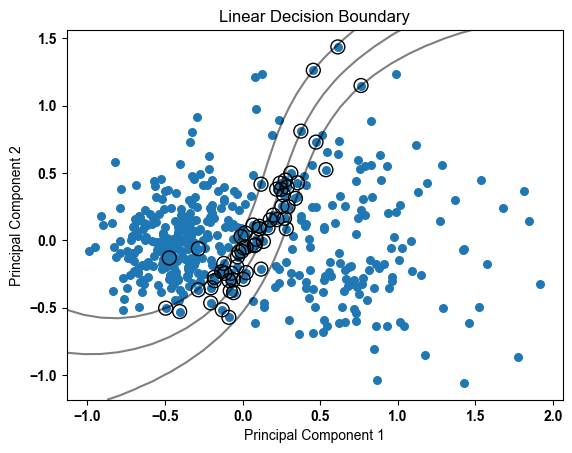

In [ ]:
pca = PCA(n_components = 2)

principal_components = pca.fit_transform(X_train_minmax)
optimized_svm.fit(principal_components, y_train)

plt.scatter(principal_components[:, 0],
            principal_components[:, 1],
            s = 30,
            cmap = plt.cm.Paired)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(
    start = xlim[0],
    stop = xlim[1],
    num = 30)

yy = np.linspace(
    start = ylim[0],
    stop = ylim[1],
    num = 30)

YY, XX = np.meshgrid(
    yy,
    xx)

xy = np.vstack([XX.ravel(), YY.ravel()]).T

Z = clf.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['-', '-', '-'])

ax.scatter(optimized_svm.support_vectors_[:, 0], optimized_svm.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.title('Linear Decision Boundary')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# K nearest neighbors

In [ ]:
neighbors = KNeighborsClassifier()

parameters = {
    'n_neighbors': np.arange(1, np.sqrt(len(X_train)) / 2 + 1, 2, dtype=int),
    'weights': ['uniform', 'distance'],
    'metric': ['cityblock', 'cosine', 'euclidean', 'l1', 'l2',
               'manhattan', 'nan_euclidean']
}

neighbors = GridSearchCV(
    neighbors,
    parameters,
    cv=10,
    scoring='f1',
    return_train_score=True,
    verbose=True
)

neighbors.fit(X_train, y_train)

optimized_neighbors = neighbors.best_estimator_
optimized_neighbors.fit(X_train, y_train)

prediction_neighbors = optimized_neighbors.predict(X_test)
print(classification_report(y_test, prediction_neighbors))

Fitting 10 folds for each of 84 candidates, totalling 840 fits
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        69
           1       1.00      0.87      0.93        45

    accuracy                           0.95       114
   macro avg       0.96      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



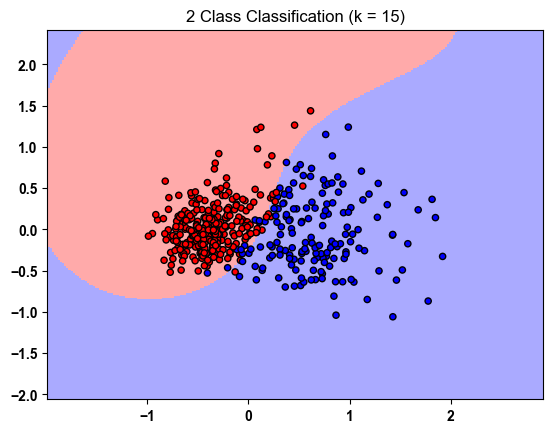

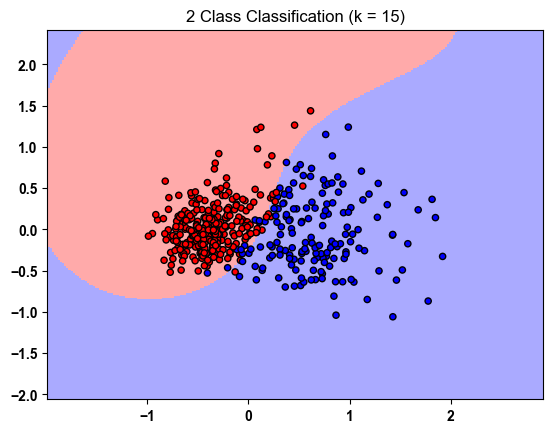

In [ ]:
h = .02

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    optimized_neighbors.fit(principal_components, y_train)

    x_min, x_max = principal_components[:, 0].min() - 1, principal_components[:, 0].max() + 1
    y_min, y_max = principal_components[:, 1].min() - 1, principal_components[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))

    Z = clf.predict(
        np.c_[xx.ravel(),
        yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(
        xx,
        yy,
        Z,
        cmap = cmap_light)

    plt.scatter(
        principal_components[:, 0],
        principal_components[:, 1],
        c = y_train,
        cmap=cmap_bold,
        edgecolor='k', s = 20)

    plt.xlim(
        xx.min(),
        xx.max())

    plt.ylim(
        yy.min(),
        yy.max())

    plt.title("2 Class Classification (k = 15)")


plt.show()

# Logistic Regressoin

In [ ]:
regression = LogisticRegression(solver='liblinear', max_iter=200)

parameters = {
    'penalty': ['l2', 'l1'],
    'C': [0.1, 0.5, 1, 2, 5, 10, 100, 1000]
}

regression = GridSearchCV(
    regression,
    parameters,
    cv=10,
    scoring='f1',
    return_train_score=True,
    verbose=True
)

regression.fit(X_train, y_train)

optimized_regression = regression.best_estimator_
optimized_regression.fit(X_train, y_train)

prediction_regression = optimized_regression.predict(X_test)
print(classification_report(y_test, prediction_regression))

Fitting 10 folds for each of 16 candidates, totalling 160 fits


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.93      1.00      0.97        69
           1       1.00      0.89      0.94        45

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Bayes

In [ ]:
gnb = GaussianNB()

parameters = {
    'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10,
                      1e-11, 1e-12, 1e-13, 1e-14, 1e-15, 1e-16, 1e-17, 1e-18,
                      1e-19, 1e-20]
}

gnb = GridSearchCV(
    gnb,
    parameters,
    cv=10,
    scoring='f1',
    return_train_score=True,
    verbose=True
)

gnb.fit(X_train, y_train)

optimized_gnb = gnb.best_estimator_
optimized_gnb.fit(X_train, y_train)

prediction_gnb = optimized_gnb.predict(X_test)
print(classification_report(y_test, prediction_gnb))

Fitting 10 folds for each of 19 candidates, totalling 190 fits
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        69
           1       1.00      0.82      0.90        45

    accuracy                           0.93       114
   macro avg       0.95      0.91      0.92       114
weighted avg       0.94      0.93      0.93       114



# Random forest

In [ ]:
rfc = RandomForestClassifier()

parameters = {
    'n_estimators': np.arange(10, 120, 10, dtype=int),
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 2]
}

rfc = GridSearchCV(
    rfc,
    parameters,
    cv=10,
    scoring='f1',
    return_train_score=True,
    verbose=True
)

rfc.fit(X_train, y_train)

optimized_rfc = rfc.best_estimator_
optimized_rfc.fit(X_train, y_train)

prediction_rfc = optimized_rfc.predict(X_test)
print(classification_report(y_test, prediction_rfc))

Fitting 10 folds for each of 66 candidates, totalling 660 fits
              precision    recall  f1-score   support

           0       0.91      0.99      0.94        69
           1       0.97      0.84      0.90        45

    accuracy                           0.93       114
   macro avg       0.94      0.91      0.92       114
weighted avg       0.93      0.93      0.93       114



# Chosen model: SVM

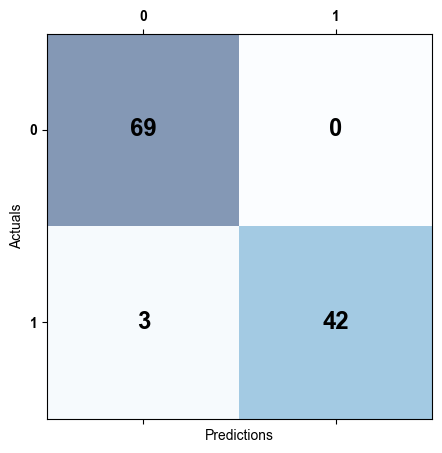

In [ ]:
matrix = confusion_matrix(y_test, prediction_svm)

fig, ax = plt.subplots(figsize=(5, 5))
colormap = colormaps['Blues']

ax.matshow(matrix, alpha=0.5, cmap=colormap)
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(x=j, y=i, s=matrix[i, j], va='center', ha='center', size='xx-large')
ax.set(xlabel='Predictions', ylabel='Actuals')

plt.show()